In [1]:
import sys
#import matplotlib.pyplot as plt
#import numpy as np
%pylab inline


T = 100
start_ind = 0
F = np.eye(4)
delta_t = 0.1
F[0,2] = delta_t
F[1,3] = delta_t
Q = 0.001*np.eye(4)
R = np.array([1,0,0,50]).reshape(2,2)
B = np.array([0, -0.5*delta_t**2,0,-delta_t]).reshape(4,1)
u = 9.8
H = np.array([1,0,0,0,0,1,0,0]).reshape(2,4)
dot_size = 10 #for plotting
custom_figsize = (15,7)
print('F:\n{}\nB:\n{}\nu:\n{}\nQ:\n{}\nR:\n{}\nH:\n{}\n'.format(F,B,u,Q,R,H))

Populating the interactive namespace from numpy and matplotlib
F:
[[1.  0.  0.1 0. ]
 [0.  1.  0.  0.1]
 [0.  0.  1.  0. ]
 [0.  0.  0.  1. ]]
B:
[[ 0.   ]
 [-0.005]
 [ 0.   ]
 [-0.1  ]]
u:
9.8
Q:
[[0.001 0.    0.    0.   ]
 [0.    0.001 0.    0.   ]
 [0.    0.    0.001 0.   ]
 [0.    0.    0.    0.001]]
R:
[[ 1  0]
 [ 0 50]]
H:
[[1 0 0 0]
 [0 1 0 0]]



The model is:
$$
X_k = FX_{k-1} + Bu + w_k, \text{where w_k from N(0,Q)} \\
Y_k = HX_{k} + v_k, \text{where v_k from N(0,R)}
$$

Kalman filter:
1. Initialization
    * $\hat{X}_{1|0} = \mu_0$
    * $\Sigma_{1|0} = \Sigma_0$
2. Prediction
    * $\hat{X}_{k|k-1} = F\hat{X}_{k-1|k-1} + BU$
    * $\Sigma_{k|k-1} = F\Sigma_{k-1|k-1}F^T + Q$
3. Filtration
    * $\hat{Y}_k = Y_k - H\hat{X}_{k|k-1}$
    * $S_k = R + H\Sigma_{k|k-1}H^T$
    * $K_k = \Sigma_{k|k-1}H^TS_k^{-1}$
    * $\hat{X}_{k|k} = \hat{X}_{k|k-1} + K_k\hat{Y}_k$
    * $\Sigma_{k|k} = \Sigma_{k|k-1} - K_kH\Sigma_{k|k-1}$

In [279]:
def mse(v1,v2):
    return np.mean(np.sum((v1-v2)**2,axis=0))


def generate_trajectory(T, starting_point):
    X = np.array(starting_point).reshape(4,1)
    Y = np.array(starting_point[:2]).reshape(2,1)

    xs = np.empty((4,T))
    for i in range(T):
        xs[:,i, None] = np.array(X)
        w = np.random.multivariate_normal(np.zeros(4), Q, 1).reshape(4,1)
        X = np.dot(F,X) + np.dot(B,u) + w

    err = np.random.multivariate_normal(np.zeros(2), R, T).T
    ys = np.dot(H,xs) + err
    return xs,ys
    
def kalman_filter(ys, starting_point, Q, R):
    kalman_xs = np.zeros((4,T),dtype=np.float64)
    kalman_xs[:,0] = np.array(starting_point,dtype=np.float64)
    kalman_xs_filtered = np.zeros((4,T),dtype=np.float64)
    kalman_xs_filtered[:,0] = np.array(starting_point,dtype=np.float64)
    kalman_covs = np.zeros((4,4,T),dtype=np.float64)
    kalman_covs_filtered = np.zeros((4,4,T),dtype=np.float64)
    kalman_covs[:,:,0] = np.zeros_like(Q)
    kalman_covs_filtered[:,:,0] = np.zeros_like(Q)
    kalman_s = np.zeros((2,2),dtype=np.float64)
    kalman_k = np.zeros((4,2),dtype=np.float64)
    kalman_y = np.zeros((2,1),dtype=np.float64)
    
    kalman_x = np.array(kalman_xs[:,0]).reshape(4,1)
    kalman_cov = np.array(kalman_covs[:,:,0])

    for i in range(1,T):
        #prediction step
        kalman_x = np.dot(F,kalman_x) + np.dot(B,u)
        kalman_cov = np.dot(np.dot(F,kalman_cov),F.T) + Q
        
        #update #in our notation X_{i|i-1}
        kalman_xs[:,i, None] = np.array(kalman_x)
        kalman_covs[:,:,i] = np.array(kalman_cov)
        
        #filtering step
        kalman_y = ys[:,i, None] - np.dot(H, kalman_x)
        kalman_s = R + np.dot(np.dot(H,kalman_cov),H.T)
        kalman_k = np.dot(np.dot(kalman_cov, H.T), np.linalg.inv(kalman_s))
        kalman_x += np.dot(kalman_k, kalman_y)
        kalman_cov -= np.dot(np.dot(kalman_k, H), kalman_cov)
        # in our notation X{i|i}
        kalman_covs_filtered[:,:,i] = np.array(kalman_cov)
        kalman_xs_filtered[:,i,None] = np.array(kalman_x)
        
    return kalman_xs, kalman_covs, kalman_xs_filtered, kalman_covs_filtered
    
def rts_smoothing(ys, kalman_xs, kalman_covs, kalman_xs_filtered, kalman_covs_filtered):
    rts_xs = np.zeros_like(kalman_xs)
    rts_ls = np.zeros_like(kalman_covs)
    rts_covs = np.zeros_like(kalman_covs)
    rts_xs[:,T-1,None] = np.array(kalman_xs[:,T-1,None])
    rts_cov = kalman_covs[:,:,0]
    rts_l = np.zeros((4,4),dtype=np.float64)
    rts_x = np.array(kalman_xs[:,T-1,None])

    for i in range(T-2,-1,-1):
        cov_filtered = kalman_covs_filtered[:,:,i]
        cov = kalman_covs[:,:,i+1]
        rts_l = np.dot(cov_filtered, np.dot(F.T, np.linalg.inv(cov)))
        rts_x = kalman_xs_filtered[:,i,None] + np.dot(rts_l, rts_x - kalman_xs[:,i+1,None])
        rts_cov = cov_filtered + np.dot(rts_l, np.dot(rts_cov - cov, rts_l.T))
        
        #update - we will need it for EM
        rts_xs[:,i,None] = np.array(rts_x)
        rts_covs[:,:,i] = np.array(rts_cov)
        rts_ls[:,:,i] = np.array(rts_l)
        
    return rts_xs, rts_covs, rts_ls
    
def em_algorithm(ys, starting_point, max_steps, epsilon):

    Q = 5*np.random.randn(4,4)
    R = np.array([1,0,0,50]).reshape(2,2)#1000*np.eye(2)#5*np.random.randn(2,2)
    #R = 10*np.random.randn(2,2)
    Qs = np.zeros((4,4,max_steps+1))
    Rs = np.zeros((2,2,max_steps+1))
    Qs[:,:,0] = np.array(Q)
    Rs[:,:,0] = np.array(R)
    steps = 0
    diff = 1000
    while steps < max_steps and diff > epsilon: 
        prev_Q = np.array(Q)
        prev_R = np.array(R)
        kalman_xs, kalman_covs, kalman_xs_filtered, kalman_covs_filtered = kalman_filter(ys, starting_point, Q, R)
        rts_xs, rts_covs, rts_ls = rts_smoothing(ys, kalman_xs, kalman_covs, kalman_xs_filtered, kalman_covs_filtered)
        old_rts_xs = np.array(rts_xs)
        rts_xs = rts_xs.reshape(4,1,T)
        kalman_xs = kalman_xs.reshape(4,1,T)
        kalman_xs_filtered = kalman_xs_filtered.reshape(4,1,T)
        new_ys = np.array(ys.reshape(2,1,T))
        # E(x_k | Y_{1:T})
        expected_xs = rts_xs
        # E(x_kx_k^t| Y_{1:t})
        expected_dot = np.einsum('ijk,ljk->ilk', rts_xs, rts_xs) + rts_covs
        # E(x_kx_{k+1}^T| Y_{1:T})
        tmp = np.einsum('ijk,jlk->ilk', rts_ls[:,:,:T-1], np.einsum('ijk,ljk->ilk', (rts_xs[:,:,1:] - kalman_xs[:,:,1:]), rts_xs[:,:,1:]) + rts_covs[:,:,1:])
        expected_dot_shift = np.einsum('ijk,ljk->ilk', kalman_xs_filtered[:,:,:T-1], rts_xs[:,:,1:]) +  tmp

        # test for correctness of expected_doc_shift
        ind = np.random.randint(0,T-1)
        actual = np.dot(kalman_xs_filtered[:,:,ind], rts_xs[:,:,ind+1].T) + np.dot(rts_ls[:,:,ind], rts_covs[:,:,1+ind] + np.dot(rts_xs[:,:,1+ind]-kalman_xs[:,:,1+ind], rts_xs[:,:,1+ind].T))
        #print(actual)
        #print(expected_dot_shift[:,:,ind])
        #print(all(np.abs(actual - expected_dot_shift[:,:,ind]) < 10**-8))
        #####################
        
        
        
        tmp1 = np.dot(F, expected_dot_shift.sum(axis=2))
        Q = 1.0/(T-1) * (expected_dot[:,:,1:].sum(axis=2) + np.dot(F, np.dot(expected_dot[:,:,:T-1].sum(axis=2),F.T)) - tmp1 - tmp1.T)
        
        dot_y1 = np.einsum('ijk,ljk->il', new_ys, new_ys)
        dot_y2 = np.dot(np.einsum('ijk,ljk->il', new_ys, expected_xs),H.T)
        #print(dot_y1.shape, dot_y2.shape)
        #print(np.dot(H, np.dot(expected_dot.sum(axis=2), H.T)).shape)
        #R = 1.0/T *(dot_y1 + np.dot(H, np.dot(expected_dot.sum(axis=2), H.T)) - dot_y2 - dot_y2.T)
        diff = ((Q-prev_Q)**2).mean() + ((R-prev_R)**2).mean()
        #print(diff)
        steps+=1
        Qs[:,:,steps] = np.array(Q)
        Rs[:,:,steps] = np.array(R)


    return Qs[:,:,:steps+1],Rs[:,:,:steps+1], steps

True Q:
[[0.001 0.    0.    0.   ]
 [0.    0.001 0.    0.   ]
 [0.    0.    0.001 0.   ]
 [0.    0.    0.    0.001]]

Q from EM in 100 steps:
[[1.25208832e+01 1.45848397e+00 1.06086513e+02 2.11810790e+01]
 [1.45848395e+00 4.97076634e+02 3.25176627e+01 3.83281134e+03]
 [1.06086513e+02 3.25176629e+01 2.12218723e+03 5.26603104e+02]
 [2.11810788e+01 3.83281134e+03 5.26603099e+02 7.66059119e+04]]

True R:
[[ 1  0]
 [ 0 50]]

R from EM in 100 steps:
[[ 1.  0.]
 [ 0. 50.]]

True Q:
[[0.001 0.    0.    0.   ]
 [0.    0.001 0.    0.   ]
 [0.    0.    0.001 0.   ]
 [0.    0.    0.    0.001]]

Best Q from EM in 100 steps:
[[ 8.73942372  0.925483   -0.73434496 -0.30114525]
 [ 1.90677862  4.026518   -3.62765842  5.43155462]
 [-2.50196995  2.366349   -0.1186115   0.18475152]
 [ 2.40657447 -5.81150765  3.63754122 -1.45858548]]



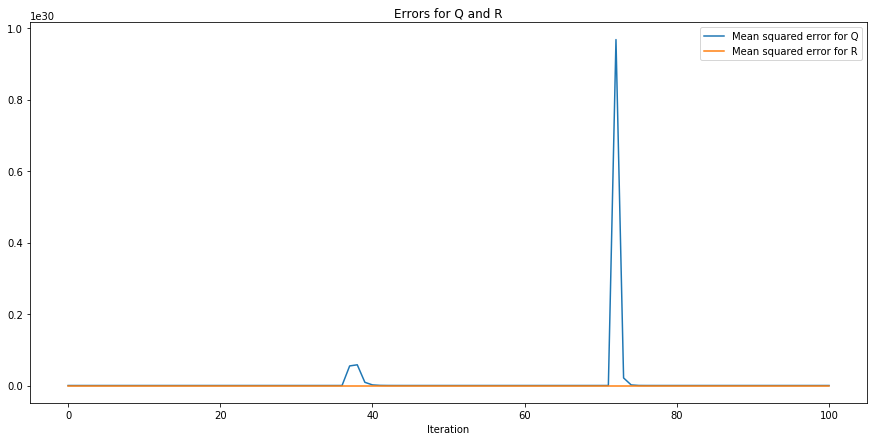

In [280]:
starting_point = [0,100, 10, 50] 


xs,ys = generate_trajectory(T,starting_point)
Qs,Rs, steps = em_algorithm(ys, starting_point, 100, 0.0000001)
Q_last = Qs[:,:,-1]
R_last = Rs[:,:,-1]
print('True Q:\n{}\n\nQ from EM in {} steps:\n{}\n'.format(Q, steps, Q_last))
print('True R:\n{}\n\nR from EM in {} steps:\n{}\n'.format(R, steps, R_last))
err_q = ((Qs - Q[:,:,np.newaxis])**2).mean(axis=(0,1))
err_r = ((Rs - R[:,:,np.newaxis])**2).mean(axis=(0,1)) 
Q_best = Qs[:,:,np.argmin(err_q)]
print('True Q:\n{}\n\nBest Q from EM in {} steps:\n{}\n'.format(Q, steps, Q_best))


plt.figure(figsize=custom_figsize)
plt.title('Errors for Q and R')
plt.plot(np.arange(steps+1), err_q, label = 'Mean squared error for Q')
plt.plot(np.arange(steps+1), err_r, label = 'Mean squared error for R')
plt.xlabel('Iteration')
plt.legend()
plt.show()

Mean squared error for real and observed: 47.9136282546
Mean squared error for real and kalman: 65.7535004714
Mean squared error for real and rts: 28.4017127938


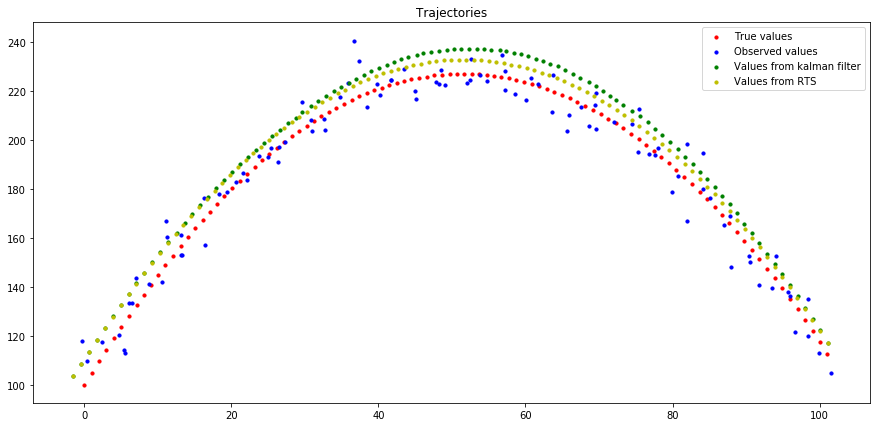

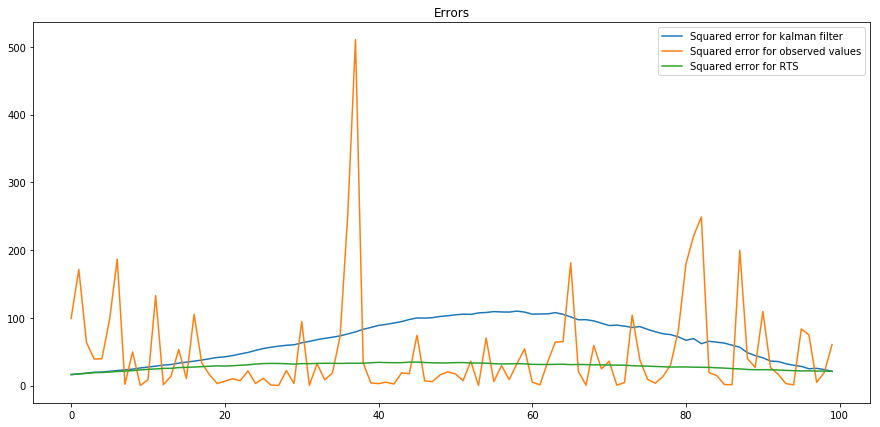

In [4]:
starting_point = [0,100, 10, 50] 


xs,ys = generate_trajectory(T,starting_point)


#kalman filter
kalman_start = np.random.multivariate_normal(starting_point, np.eye(4) * 10)
kalman_xs, kalman_covs, kalman_xs_filtered, kalman_covs_filtered = kalman_filter(ys, kalman_start, Q, R)
rts_xs, rts_covs, rts_ls = rts_smoothing(ys, kalman_xs, kalman_covs, kalman_xs_filtered, kalman_covs_filtered)

err_kal = np.sum((xs[:2,:]-kalman_xs[:2,:])**2,axis=0)
err_y = np.sum((xs[:2,:]-ys)**2,axis=0)
err_rts = np.sum((xs[:2,:]-rts_xs[:2,:])**2,axis=0)

print('Mean squared error for real and observed: {}'.format(mse(xs[:2,:],ys)))
print('Mean squared error for real and kalman: {}'.format(mse(xs[:2,:], kalman_xs[:2,:])))
print('Mean squared error for real and rts: {}'.format(mse(xs[:2,:], rts_xs[:2,:])))





plt.figure(1, figsize=custom_figsize)
plt.title('Trajectories')
plt.scatter(xs[0,start_ind:],xs[1,start_ind:],c='r',s=dot_size, label='True values')
plt.scatter(ys[0,start_ind:],ys[1,start_ind:],c='b',s=dot_size, label='Observed values')
plt.scatter(kalman_xs[0,start_ind:], kalman_xs[1,start_ind:], c='g', s=dot_size, label='Values from kalman filter')
plt.scatter(rts_xs[0,start_ind:], rts_xs[1,start_ind:], c='y', s=dot_size, label='Values from RTS')
plt.legend()

plt.figure(2, figsize=custom_figsize)
plt.title('Errors')
plt.plot(np.arange(T), err_kal, label = 'Squared error for kalman filter')
plt.plot(np.arange(T), err_y, label = 'Squared error for observed values')
plt.plot(np.arange(T), err_rts, label = 'Squared error for RTS')
plt.xlabel('Iteration')
plt.legend()
plt.show()


In [114]:
# Test einsum xs
tmp_xs = kalman_xs.reshape(4,1,T)
x = np.einsum('ij...,lj...->il...',tmp_xs, tmp_xs)
x2 = np.einsum('ijk,ljk->ilk', tmp_xs, tmp_xs)
y = np.einsum('ijk,ljk->ilk', kalman_covs, kalman_covs)
test = True
for ind in range(T):
    test = test and (all(x[:,:,ind] == np.dot(tmp_xs[:,:,ind], tmp_xs[:,:,ind].T)) and all(np.dot(tmp_xs[:,:,ind], tmp_xs[:,:,ind].T) == x2[:,:,ind]))
print('Is test result for xs good?: {}'.format(test))
test = True
for ind in range(T):
    test = test and all(np.abs(y[:,:,ind] - np.dot(kalman_covs[:,:,ind], kalman_covs[:,:,ind].T)) < 10**(-10))
print('Is test result for covs good?: {}'.format(test))

Is test result for xs good?: True
Is test result for covs good?: True
